In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mitsuba
mitsuba.set_variant('gpu_acoustic')
from enoki import *
cuda_set_log_level(0)

2021-06-28 15:27:27 INFO main [optix_api.cpp:56] Dynamic loading of the Optix library ..

In [4]:
def make_shoebox_scene(emitter_pos, sensor_pos, box_dimensions, radius, max_time, time_steps, 
                       spp, bins, rfilter, max_depth, samples_per_pass, scattering,absorption, hide_sensor=True):
    
    from mitsuba.core import ScalarTransform4f

    def transform(scale=None, rotate=None, translate=None):
        if translate is None:
            translate = [0, 0, 0]
        if scale is None:
            scale = [1, 1, 1]
        if rotate is None:
            rotate = ([0, 0, 0], 0)

        a = ScalarTransform4f.scale(scale)
        b = ScalarTransform4f.rotate(*rotate)
        c = ScalarTransform4f.translate(translate)
        return c * b * a

    global_translation = transform(translate=np.array(box_dimensions) / 2)

    scene = {
        "type": "scene",
        "bsdf_neutral": {
            "type": "acousticbsdf",
            "scattering": {
                "type": "spectrum",
                "value": scattering
            },
            "absorption": {
                "type": "spectrum",
                "value": absorption
            }
        },
        "emitter_shape": {
            "id": "emitter",
            "type": "sphere",
            "radius": radius,
            "to_world": transform(translate=emitter_pos),
            "emitter": {
                "type": "area",
                "radiance": {
                    "type": "uniform",
                    "value": 1
                }
            },
            "bsdf": {
                "type": "null"
            }
        },
        "sensor": {
            "type": "microphone",
            "to_world": transform(translate=sensor_pos),
            "sampler": {
                "type": "independent",
                "sample_count": spp
            },
            "myfilm": {
                "type": "tape",
                "time_steps": time_steps,
                "wav_bins": len(bins),
                "rfilter": rfilter
            }  
        },
        "shoebox": {
            "id": "shoebox",
            "type": "obj",
            "filename": "../resources/cuberoom.obj",
            "bsdf": {
                "type": "ref",
                "id": "bsdf_neutral"
            },
            "to_world": global_translation * transform(scale=np.array(box_dimensions) / 2)
        },
        "integrator": {
            "type": "acousticpath",
            "max_depth": int(max_depth),
            "max_time": max_time,
            "wavelength_bins": ','.join(str(x) for x in bins),
            "samples_per_pass": samples_per_pass
        }
    }
    return scene

def get_vals(data, size, copy=True):
    return np.array(data, copy=copy).reshape(size)


def EDC(x):
    energy = x * 0.
    # Compute the whole integral
    total = np.trapz(x, axis=0)
    print(total.shape)
    for i in range(x.shape[0]):
        energy[i] = (np.trapz(x[i:], axis=0) / total)
    return energy


def run_simulation(config):
    scene_dict = make_shoebox_scene(**config)
    scene = load_dict(scene_dict)

    size = scene.sensors()[0].film().size()

    sensor = scene.sensors()[0]
    integrator = scene.integrator()

    status = integrator.render(scene, sensor)
    assert status
    
    film = sensor.film()

    data = film.get_histogram().data()
    counts = film.get_histogram().counts()

    vals = get_vals(data, film.size())
    vals_count = get_vals(counts, film.size())
    
    total_samples = config['time_steps'] * config['spp']
 
    edc = vals / total_samples
    edc = np.nan_to_num(edc)
    edc = EDC(vals)
    edc_db = 10 * np.log10(edc)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(15, 5))
    ax1.plot(edc)
    ax1.set_title("Energy")
    ax2.plot(edc_db)
    ax2.set_title("Energy [dB]")
    ax3.plot(vals)
    ax3.set_title("Recorded")
    ax4.plot(vals_count)
    ax4.set_title("Counts")
    
    return edc, edc_db

2021-06-28 16:05:44 DEBUG main [OBJMesh] Loading mesh from "cuberoom.obj" ..

2021-06-28 16:05:44 DEBUG main [OBJMesh] "cuberoom.obj": read 12 faces, 24 vertices (912 B in 0ms)

2021-06-28 16:05:44 INFO main [Scene] Building scene in OptiX ..

2021-06-28 16:07:09 INFO main [TimeDependentIntegrator] Rendering finished. (took 1.4112m)

(3,)


<ipython-input-4-93f97475aa67>:123: RuntimeWarning: divide by zero encountered in log10
  edc_db = 10 * np.log10(edc)


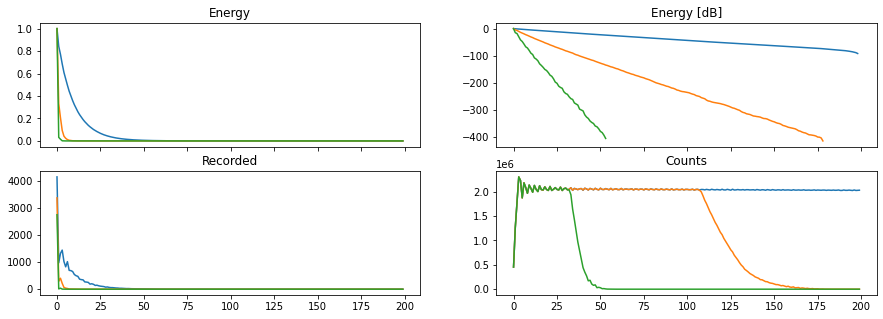

In [5]:
from mitsuba.core.xml import load_string, load_dict

config = {
    "bins":  [1, 2, 3],
    "absorption": [(1, 0.1), (2, 0.5), (3, 0.9)],
    "scattering": 0.0,
    "max_time": 2,
    "time_steps": 200,
    "spp": 10000,
    "samples_per_pass": 1000,
    "box_dimensions": [5, 5, 5],
    "emitter_pos": [1, 1, 1],
    "sensor_pos": [2, 2, 1],
    "radius": .1,  
    "max_depth": 500,
    "rfilter": {
        "type": "box",
        "radius": 0.5
    }
}

edc, edc_db = run_simulation(config)


In [ ]:
np.save('data/RT-EDC-box-5-5-5.npy', edc_db)